## Informacje o procesorze

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 12 12:33:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Instalacja i wersje pakietów

In [ ]:
pip install colorama

In [ ]:
import torch
import time
import torchvision
import pandas as pd
import numpy as np
import matplotlib as plt
from colorama import Fore

In [ ]:
!python --version
print('Torch: ', torch.__version__)
print('Torchvision: ', torchvision.__version__)
print('Pandas: ', pd.__version__)
print('Numpy: ', np.__version__)
print('Matplotlib: ', plt.__version__)

Python 3.10.12
Torch:  2.2.1+cu121
Torchvision:  0.17.1+cu121
Pandas:  2.0.3
Numpy:  1.25.2
Matplotlib:  3.7.1


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# Pobranie i przygotowanie zestawu danych


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Zmniana do wymaganych wymiarów dla AlexNet
    transforms.Grayscale(num_output_channels=3),  # Konwersja do 3 kanałów
    transforms.ToTensor(),
])

# Pobranie zbioru testowego i treningowego w stosunku 70/10
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Złączenie zbioru testowego i treningowego
combined_data = ConcatDataset([mnist_train, mnist_test])

100%|██████████| 9912422/9912422 [00:00<00:00, 223858710.25it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 23710255.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 83026896.49it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7307452.54it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
print(f'Ilość danych ogółem: ', len(combined_data))

print(f'{Fore.GREEN}Obrazy zostały załadowane pomyślnie!{Fore.BLACK}')

Ilość danych ogółem:  70000
Obrazy zostały załadowane pomyślnie!


# Funkcje niestandardowe

___

In [ ]:
import random

# Ustawienie ziarna losowości dla powtarzalności wyników
def set_seed(seed_value: int = 42):
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed_value)
    random.seed(seed_value)

In [ ]:
from torch.utils.data import random_split

def split_dataset(dataset):
  # Obliczanuie długości dla zbioru testowego i treningowego w stosunku 80/20
  train_size = int(0.8 * len(dataset))
  validation_size = len(dataset) - train_size

  # Podzielenie na dwa zestawy danych
  train_ds, validation_ds = random_split(dataset, [train_size, validation_size])
  return train_ds, validation_ds

In [ ]:
import pandas as pd

INDEXES = ["Czas treningu", "Dokładność treningowa", "Dokładność walidacyjna", "Strata treningowa", "Strata walidacyjna"]

def create_df(output_data: dict) -> pd.DataFrame:
  return pd.DataFrame(output_data, index=INDEXES)

## AlexNet model

In [ ]:
from torchvision.models import alexnet
import torch.nn as nn
import torch.optim as optim

def create_alexnet_model():
    model = alexnet(pretrained=True)
    # Dostosowanie do 10 klas dla zestawu MNIST
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    return model, criterion, optimizer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from collections import defaultdict

def train_alexnet_on_mnist(test_loader, val_loader, epochs=10, device=DEVICE) -> list:
    output_data_alexnet = defaultdict(list)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss = running_loss / len(val_loader)
        test_accuracy = 100 * correct / total

        output_data_alexnet[epoch] = [train_accuracy, test_accuracy, train_loss, test_loss]
        print(f'Epoch {epoch+1}/{epochs} | loss: {train_loss:.2f}% - accuracy: {train_accuracy:.2f}%, val_loss: {test_loss:.2f}% - val_accuracy: {test_accuracy:.2f}%')

    return output_data_alexnet


## Plotting

In [ ]:
import matplotlib.pyplot as plt

def plot_results(model_df: pd.DataFrame) -> None:
    # Transpozycja DataFrame dla łatwiejszego plotowania
    df_t = model_df.T

    # Tworzenie wykresu
    plt.figure(figsize=(10, 6))

    # Plotowanie dokładności
    plt.plot(df_t.index, df_t["Dokładność treningowa"], '-o', label='Dokładność testowa', color='red')
    plt.plot(df_t.index, df_t["Dokładność walidacyjna"], '-o', label='Dokładność walidacyjna', color='orange')

    # Plotowanie straty
    plt.plot(df_t.index, df_t["Strata treningowa"], '-o', label='Strata testowa', color='blue')
    plt.plot(df_t.index, df_t["Strata walidacyjna"], '-o', label='Strata walidacyjna', color='green')

    # Dodanie tytułu i etykiet
    plt.title('Dokładność i strata w zależności od ilości danych wejściowych')
    plt.xlabel('Ilość danych wejściowych')
    plt.ylabel('Wartości [%]')

    # Dodanie legendy
    plt.legend()

    # Pokazanie wykresu
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(data) -> None:
    """ Tworzenie wykresów dokładności i straty dla modelu

    Args:
        history (model): Wytrenowany model
    """
    # Wykresy dokładności i straty
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Wykres dokładności modelu
    axs[0].plot(data['accuracy'], label=f'Dokładność testowa')
    axs[0].plot(data['val_accuracy'], label='Dokładność walidacyjna')
    axs[0].set_title(f'Dokładność modelu')
    axs[0].set_ylabel('Dokładność [%]')
    axs[0].set_xlabel('Liczba epok')
    axs[0].legend(loc='lower right')
    axs[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}'))

    # Wykres starty modelu
    axs[1].plot(data['loss'], label='Strata treningowa')
    axs[1].plot(data['val_loss'], label='Strata walidacyjna')
    axs[1].set_title(f'Strata modelu')
    axs[1].set_ylabel('Strata [%]')
    axs[1].set_xlabel('Liczba epok')
    axs[1].legend(loc='upper right')
    axs[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

    plt.tight_layout()
    plt.show()

# Badanie optymalnej ilości wolumenu danych

In [ ]:
# Ustawienie ziarna dla reprodukowalności
np.random.seed(42)

# Generowanie losowej liczby całkowitej z przedziału od 0 do 100
seeds = [np.random.randint(0, 101) for i in range(0, 7)]
seeds

[51, 92, 14, 71, 60, 20, 82]

In [ ]:
from collections import defaultdict
from torch.utils.data import DataLoader, Subset

sizes = list(range(10000, 80000, 10000))
output_data = defaultdict()

for (i, size) in enumerate(sizes):

    # Ustawienie ziarna dla reprodukowalności
    set_seed(seeds[i])

    # Podział danych w stosunku 80/20
    indices = torch.randperm(len(combined_data))[:size]
    combined_data_sliced = Subset(combined_data, indices)
    train_dataset, validation_dataset = split_dataset(combined_data_sliced)

    # Utworzenie Data Loaders dla zestawu treningowego i testowego
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

    # Utworzenie modelu AlexNet
    model, criterion, optimizer = create_alexnet_model()

    # Trening model
    print(f'\n{Fore.GREEN}---------------- Trening modelu AlexNet: {i+1}/{size} ----------------\n{Fore.BLACK}')

    start_time = time.time()
    output_dict = train_alexnet_on_mnist(train_loader, val_loader)
    end_time = time.time()

    training_time = end_time - start_time
    print(f'Trening ukończony w: {training_time} sekund')

    output_data[size] = [training_time]
    for i in output_dict: output_data[size].append(i)

    del indices, combined_data_sliced, train_loader, val_loader, model


---------------- Trening modelu AlexNet: 1/10000 ----------------

Epoch 1/10 | loss: 2.09% - accuracy: 19.14%, val_loss: 1.77% - val_accuracy: 25.90%
Epoch 2/10 | loss: 1.34% - accuracy: 49.14%, val_loss: 0.49% - val_accuracy: 84.95%
Epoch 3/10 | loss: 0.41% - accuracy: 88.16%, val_loss: 0.18% - val_accuracy: 95.15%
Epoch 4/10 | loss: 0.20% - accuracy: 94.55%, val_loss: 0.08% - val_accuracy: 97.35%
Epoch 5/10 | loss: 0.11% - accuracy: 96.75%, val_loss: 0.19% - val_accuracy: 95.85%
Epoch 6/10 | loss: 0.11% - accuracy: 96.53%, val_loss: 0.06% - val_accuracy: 97.80%
Epoch 7/10 | loss: 0.07% - accuracy: 97.66%, val_loss: 0.15% - val_accuracy: 95.70%
Epoch 8/10 | loss: 0.07% - accuracy: 97.74%, val_loss: 0.20% - val_accuracy: 96.30%
Epoch 9/10 | loss: 0.09% - accuracy: 97.58%, val_loss: 0.16% - val_accuracy: 96.25%
Epoch 10/10 | loss: 0.07% - accuracy: 97.96%, val_loss: 0.08% - val_accuracy: 97.90%
Trening ukończony w: 187.22752332687378 sekund

---------------- Trening modelu AlexNet: 2/

In [ ]:
# Convert results to a pandas DataFrame
results_df = create_df(output_data)
results_df

,10000,20000,30000,40000,50000,60000,70000
Czas treningu,187.227523,377.986554,541.368328,691.352818,928.326262,1032.523797,1193.343845
Dokładność treningowa,97.962500,98.500000,98.608333,98.534375,98.602500,98.827083,98.639286
Dokładność walidacyjna,97.900000,98.875000,98.816667,98.850000,98.900000,99.050000,98.950000
Strata treningowa,0.073099,0.062864,0.054470,0.061069,0.053837,0.047851,0.053892
Strata walidacyjna,0.083423,0.040918,0.059498,0.052216,0.048604,0.038953,0.052289


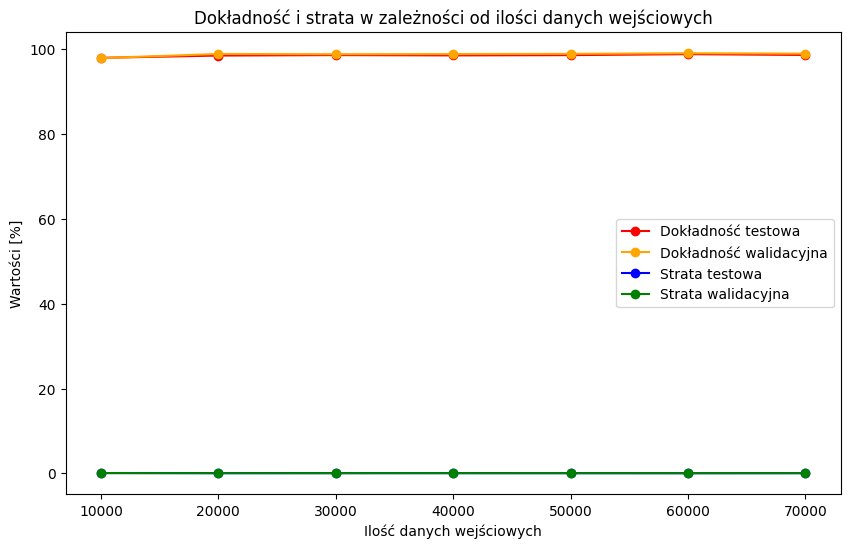

In [ ]:
plot_results(results_df)

#Ilośc epok

In [ ]:
SIZE = 30000
EPOCHS = 50

In [ ]:
# Ustawienie ziarna dla reprodukowalności
set_seed(42)

# Podział danych w stosunku 80/20
indices = torch.randperm(len(combined_data))[:SIZE]
combined_data_sliced = Subset(combined_data, indices)
train_dataset, validation_dataset = split_dataset(combined_data_sliced)

# Utworzenie Data Loaders dla zestawu treningowego i testowego
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

# Utworzenie modelu AlexNet
model, criterion, optimizer = create_alexnet_model()

# Trening model
print(f'\n{Fore.GREEN}---------------- Trening modelu AlexNet na 50 epokach ----------------\n{Fore.BLACK}')

start_time = time.time()
results = train_alexnet_on_mnist(train_loader, val_loader, EPOCHS)
end_time = time.time()

training_time = end_time - start_time
print(f'Trening ukończony w: {training_time} sekund')


---------------- Trening modelu AlexNet na 50 epokach ----------------

Epoch 1/50 | loss: 0.32% - accuracy: 89.70%, val_loss: 0.09% - val_accuracy: 97.80%
Epoch 2/50 | loss: 0.10% - accuracy: 97.04%, val_loss: 0.06% - val_accuracy: 98.48%
Epoch 3/50 | loss: 0.08% - accuracy: 97.84%, val_loss: 0.08% - val_accuracy: 98.00%
Epoch 4/50 | loss: 0.08% - accuracy: 97.89%, val_loss: 0.07% - val_accuracy: 98.08%
Epoch 5/50 | loss: 0.07% - accuracy: 98.25%, val_loss: 0.06% - val_accuracy: 98.60%
Epoch 6/50 | loss: 0.06% - accuracy: 98.33%, val_loss: 0.06% - val_accuracy: 98.58%
Epoch 7/50 | loss: 0.06% - accuracy: 98.30%, val_loss: 0.09% - val_accuracy: 98.18%
Epoch 8/50 | loss: 0.06% - accuracy: 98.55%, val_loss: 0.04% - val_accuracy: 98.82%
Epoch 9/50 | loss: 0.05% - accuracy: 98.75%, val_loss: 0.05% - val_accuracy: 99.05%
Epoch 10/50 | loss: 0.05% - accuracy: 98.89%, val_loss: 0.08% - val_accuracy: 98.40%
Epoch 11/50 | loss: 0.05% - accuracy: 98.81%, val_loss: 0.06% - val_accuracy: 98.65%
E

In [ ]:
from collections import defaultdict

metrics = defaultdict(list)
for val in results.values():
  metrics['accuracy'].append(val[0])
  metrics['val_accuracy'].append(val[1])
  metrics['loss'].append(val[2])
  metrics['val_loss'].append(val[3])

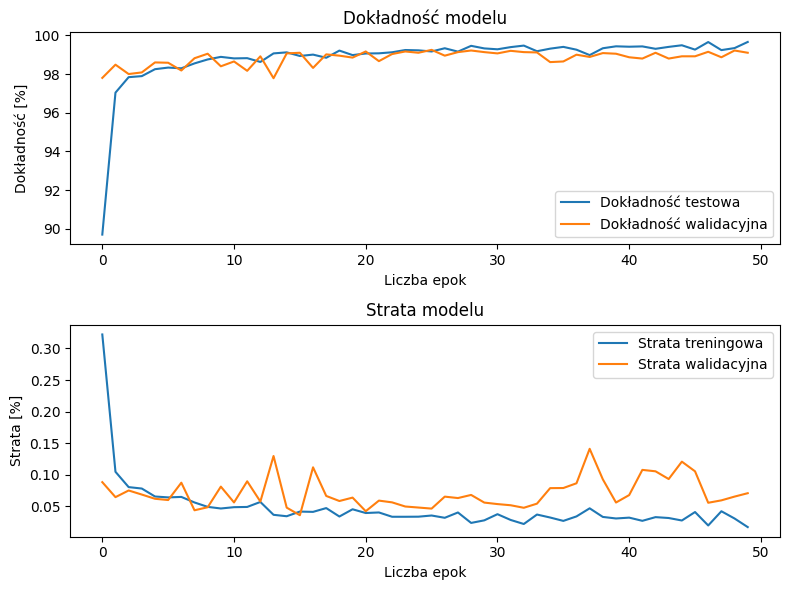

In [ ]:
plot_accuracy_and_loss(metrics)